# Team Convolution Workbook: ResNet-18 Submission

We have created a general structure for our notebooks. This structure is followed below and changes can be made to it, however, it provides the user with an easy starting point for testing different types of network architectures, data augmentation techniques, and hyperparameters. As is explained in the README.md, we have attempted to make our project as modular as possible by encapuslating any "significant" amount of code in .py files. This has allowed for the members of the team who are investigating the best network architectures and hyperparameters to quickly make use of any new functionality that is implemented and allows the notebook to be kept clean and simple.


The ResNet-18 submission notebook achieved Team Convolution's best final Area Under Receiver Operating Characteristic Curve (AUC - ROC) score at 0.98746. 
The model used is a convolutional neural network that is 18 layers deep, pretrained on more than a million images from the ImageNet database. As a result of pretraining the network architecture has learned rich feature representations for a wide range of images which has been combined with the network architecture and data augmentation to form this model appropriate to classify the four classes of Covid-19, Lung opacity, Pneumonia and Normal.
ResNet-18 was decided as one of the two model options for the final submission, as throughout comparison with other models (and ResNet variants), it pertained to result in the best validation accuracies with the given AUC-ROC metric.

In [ ]:
!pip install pycm livelossplot
!pip install wandb
%pylab inline

     |████████████████████████████████| 71kB 5.6MB/s eta 0:00:011
     |████████████████████████████████| 573kB 12.5MB/s 
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import os
import random
import copy
import numpy as np
import torch
from torchvision import models, datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedShuffleSplit


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True


device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Download data (google colab only, this may cause some path issues)

In [ ]:
# Run line below if you want to download data directly from kaggle
# kaggle_download("kaggle.json")


#Run lines below if you want to mount the google drive to obtain data
#from google.colab import drive
#drive.mount('/content/gdrive/')

#if zip file manually uploaded run this line
##!unzip gdrive/MyDrive/acse4-ml-2020.zip #change to correct file directory

Mounted at /content/gdrive/


## Load Images

Here data is loaded using ImageFolder - https://pytorch.org/vision/stable/datasets.html#id30


In [ ]:
# set normalization means and stdevss
means = [0.485, 0.456, 0.406] 
stdevs = [0.229, 0.224, 0.225] # <----- these are the ones for ImageNet, we use them as we are transfer learning

# set how many channels you would like for the data
channels = 3

full_data_set = get_data("xray-data/xray-data/train", transform=None, rgb=True)

# load in validation and trainset apply augmentations to the trainset, normalizations to both. Makes the split using stratified shuffle split
trainset, validset, _ = get_data_augmented("xray-data/xray-data/train", "xray-data/xray-data/testouter", 0.15, means, stdevs)

### Some initial plots to check the dataset has been loaded correctly


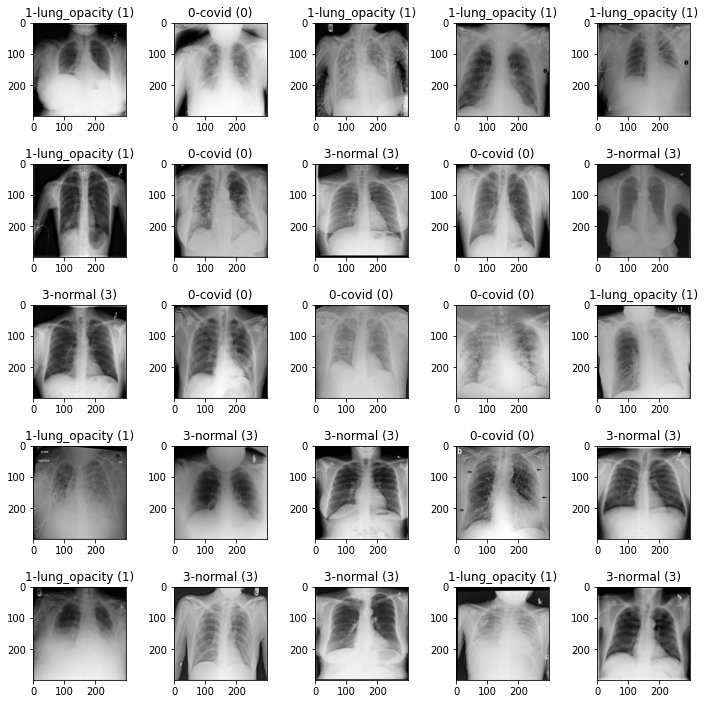

In [ ]:
visualise_rand(full_data_set)

----------------------------------------------------------
# Network Training

This section of the notebook is where models are trained. The training can be split into three sections which the user may like to run:

----------------------
1) Training the model with the validation and training splits.
    - User manually sets hyperparameters
    - Doesn't preform a grid search i.e. runs only for one set of parameters
    - Displays a LiveLoss plot of how the area under the curve (AUC-ROC) accuracy changes with epoch
    - outputs a model trained test set  with the validation split

----------------------
2) Train the model using weights and biasis 
    - Allows the user to perform a grid search that is tracked from wandb
    - Lots of useful metrics displayed
    - Doesn't output a trained model
    - Some grid parameters (optimizer and model) need to be set from within utils/wandb.py
    - NOTE: this will take a while to run as it will preform a grid search!
    
----------------------    
3) Train the model on the full data set (produce submission model)
    - User manually sets hyperparameters
    - This can be seen as a "complete model" i.e. one from which we would make predictions for submission
    
----------------------   

Before you carry on with this lets set the Network. See next two cells.

NOTE: if you would like to simply reproduce our submission model skip to part 3 in the notebook (after running the next two cells)

In [ ]:
"""
This cell shows how you can import Networks that are custom made.

The Network classes for networks that are user defined can be found in utils/networks.py

The example here shows how you would import the LeNet5() architecture from /networks.py

list of available options:

LeNet5()  <----- LeNet5 network with (1, 299, 299) input size

AlexNet() <----- AlexNet network with (1, 299, 299) input size
"""
#Net = LeNet5()
#print(Net) # <----- print the network to check it looks alright!

In [ ]:
"""
This cell shows how you can import networks directly from pytorch

see https://pytorch.org/vision/stable/models.html for list of available models

Can import either a trained or pretrained network using model.<model name>(pretrained=True)

The user will need to change the final layer of the network such that it has 4 output features
as is shown below!
"""

Net = models.resnet18(pretrained=True)
Net.fc = nn.Linear(in_features=512, out_features=4)
print(Net)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

## 1) Training the model with the validation and test splits.

##### Set training hyperparameters for training with validation split

In [ ]:
# Set Training Hyperparameters for training with validation split
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 500
n_epochs = 15
seed = 42

# set data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validset, batch_size=test_batch_size, shuffle=False, num_workers=0)

# set seed
set_seed(seed)
# copy the model
model = copy.deepcopy(Net).to(device)
# pick an optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = momentum)
# pick a loss criterion
criterion = nn.CrossEntropyLoss()

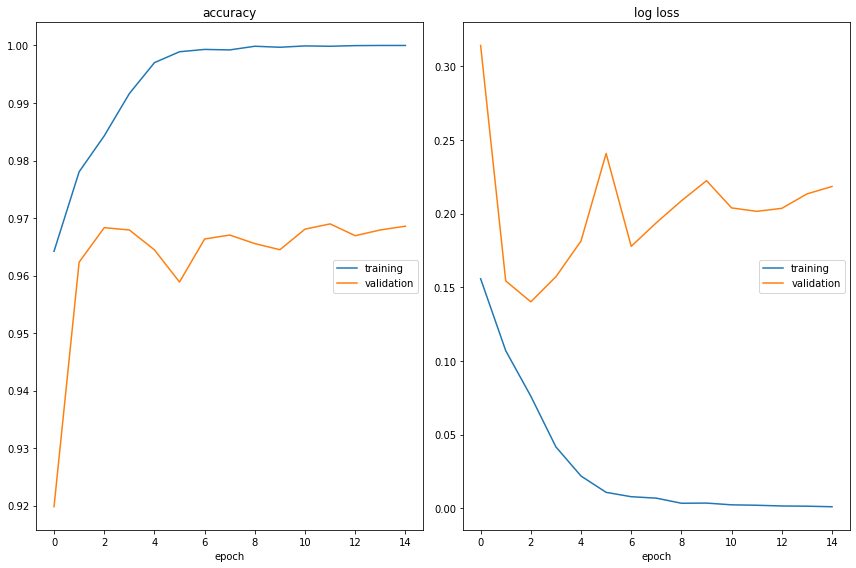

accuracy
	training         	 (min:    0.964, max:    1.000, cur:    1.000)
	validation       	 (min:    0.920, max:    0.969, cur:    0.969)
log loss
	training         	 (min:    0.001, max:    0.156, cur:    0.001)
	validation       	 (min:    0.140, max:    0.314, cur:    0.218)


In [ ]:
model = train_model(model, optimizer, criterion, train_loader, validation_loader, channels, device, lr, momentum, batch_size, test_batch_size, n_epochs)

## 2) Wandb.ai grid search run
##### Set params for grid search

In [ ]:
# Set Training Hyperparameters for training with validation split (these wont all be used in the grid search)
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 500
n_epochs = 15
seed = 42

In [ ]:
#Hyperparameters that we mat want to vary during our run, can be extended upon as needed
hyperparameters = {
    "learning_rate": lr,
    "momentum": momentum,
    "batch_size": batch_size,
    "n_epochs": n_epochs,
    "test_batch_size": test_batch_size,
    "channels": channels
}

In [ ]:
#Sweep configuration 1: value ranges for a grid search, program itself determines reliable hyperparameters to test over
bayes_sweep_config = {
    "name": "bayes",
    "method": "bayes",
    "metric": {
        "name": "validation_roc_auc",
        "goal": "maximize"
    },
    "parameters": {
        "learning_rate": {
            "min": 1e-4,
            "max": 1e-1
        },
        "momentum": {
            "min": 0.0,
            "max": 0.99999
        }
    },
    "early_terminate": {
        "type": "hyperband",
        "max_iter": hyperparameters["n_epochs"] // 2,
        "s": 5
    }
}

In [ ]:
# sets the grid sweep configurations
# this particular example will run a grid sweep for learning rate and weight_decay using AdamW optimizer
grid_sweep_config = {
    "name": "grid_search",
    "method": "grid",
    "parameters": {
        "learning_rate": {            #grid search value is happening
            "values": [1e-4]  #grid search values
        },
        "weight_decay": {
            "values": [0, 0.1]
        }
    },
    "early_terminate": {
        "type": "hyperband",
        "max_iter": hyperparameters["n_epochs"] // 2, #stops earlier if a bad run
        "s": 5
    }
}

##### Run the grid search

In [ ]:
model = copy.deepcopy(Net).to(device)

sweep_wandb(seed, model, device, trainset, validset, grid_sweep_config, hyperparameters, count=4, entity="4-2-convolution", project="ResNet_augment")

## 3) Start Training with validation and  training set (produce submission model)
##### Set params for final training

In [ ]:
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 500
n_epochs = 15
seed = 42

model = copy.deepcopy(Net).to(device) 
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = momentum)                 
criterion = nn.CrossEntropyLoss()

###### Start training on full dataset (i.e. train + validation)

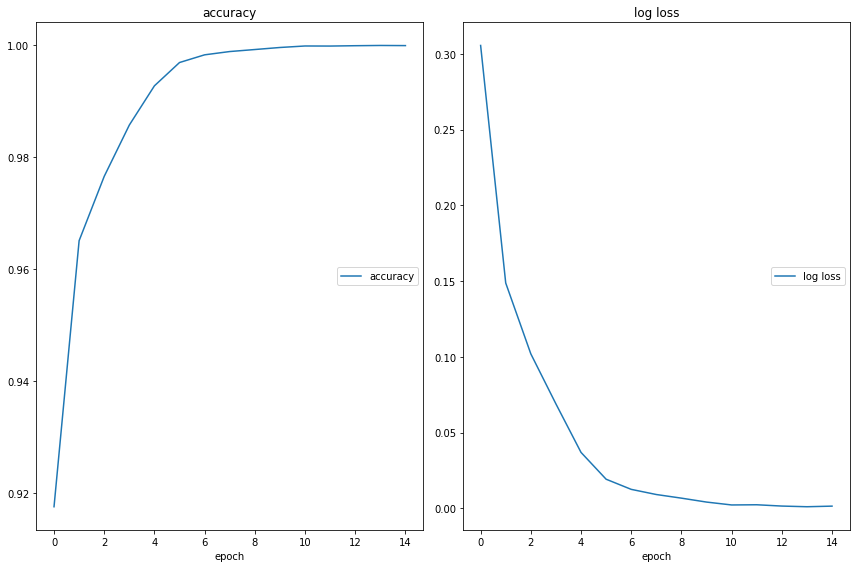

accuracy
	accuracy         	 (min:    0.918, max:    1.000, cur:    1.000)
log loss
	log loss         	 (min:    0.001, max:    0.306, cur:    0.002)


In [ ]:
train_loader = DataLoader(full_data_set, batch_size=batch_size, shuffle=True, num_workers=0) # loads the full dataset i.e. validation + training
model = train_on_full(model, optimizer, criterion, train_loader, channels, 
                      device, lr, momentum, batch_size, test_batch_size, n_epochs)

### This is where we evaluate and save the model

Models will be saved in the /saved_models folder. 

csv files containing our predictions for the test set will be saved in the /submissioncsv folder

The cell below is where the user can, and should, control the save file names from to avoid things being overwritten!

#### Set save names for model and prediciton/submission csv

These need to be changed by the individual

In [ ]:
model_save_name = "augmentation_Resnet18_pretrain.pt"       # name to save model under 
submission_csv_name = "augmentation_Resnet18_pretrain.csv"  # name to save submission csv under

In [ ]:
# saving the trained model
torch.save(model.state_dict(), "saved_models/" + model_save_name)

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
class CustomDataSet(Dataset):
    """
    Custom data loader so that files are loaded and in the correct order
    This was only really necessary for the purposes of submitting the csv to kaggle in correct order
    """
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = ["test_" + str(i) + ".png" for i in range(len(os.listdir(main_dir)))]

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [ ]:
my_dataset = CustomDataSet("xray-data/test_outer/test", transform=transform_train)
test_loader = DataLoader(my_dataset , batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

In [ ]:
# get predictions made by model on my_dataset
def get_predictions(model, X, device, channels=3):
    """
    Get predictions on a set of data X
    """
    model.eval()
    y_preds = []
    for x in X:
        with torch.no_grad():
            x = x.to(device)
            a2 = model(x.view(-1, 3, 299, 299))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            y_preds.append(y_pred.item())

    return y_preds
preds = get_predictions(model, my_dataset, device, channels=3)
print('done')

In [ ]:
write_file(submission_csv_name, preds)